In [1]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [2]:
file_name = 'Housing.csv'

In [3]:
dataset = pd.read_csv(file_name)

In [4]:
dataset.shape

(545, 13)

In [5]:
dataset.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [6]:
dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [7]:
from sklearn.preprocessing import OneHotEncoder
#Extract categorical columns from the dataframe
#Here we extract the columns with object datatype as they are the categorical columns
categorical_columns = dataset.select_dtypes(include=['object']).columns.tolist()

#Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(dataset[categorical_columns])

#Create a DataFrame with the one-hot encoded columns
#We use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([dataset, one_hot_df], axis=1)

# Drop the original categorical columns
dataset = df_encoded.drop(categorical_columns, axis=1)

In [8]:
dataset

,price,area,bedrooms,bathrooms,stories,parking,mainroad_no,mainroad_yes,guestroom_no,guestroom_yes,...,basement_yes,hotwaterheating_no,hotwaterheating_yes,airconditioning_no,airconditioning_yes,prefarea_no,prefarea_yes,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,2,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1,12250000,8960,4,4,4,3,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,12250000,9960,3,2,2,2,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,12215000,7500,4,2,2,3,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,11410000,7420,4,1,2,2,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,2,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
541,1767150,2400,3,1,1,0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
542,1750000,3620,2,1,1,0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
543,1750000,2910,3,1,1,0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [9]:
target_col = dataset.columns[0]
target_col

'price'

In [10]:
train_size = 0.8
train_points = int(train_size*len(dataset))
train_df = dataset.iloc[:train_points]
test_df = dataset.iloc[train_points:]

In [11]:
train_points = int(train_size*len(train_df)) #further split train dataset to train and calibration
cal_df = train_df.iloc[train_points:]
train_df = train_df.iloc[:train_points]

In [12]:
df_dict = {'train': train_df, 'calibration': cal_df, 'test': test_df}
for key, value in df_dict.items():
    print(f'{key} dataframe shape: {value.shape}')

train dataframe shape: (348, 21)
calibration dataframe shape: (88, 21)
test dataframe shape: (109, 21)


In [13]:
# figsize = (16, 8)
# cal_df.set_index(time_col)[target_col].plot(figsize=figsize);

### **Base model fitting (prior to fit mauq)**

In [14]:
from sklearn.linear_model import Ridge
train_X = train_df.iloc[:, 1:]
train_y = train_df.iloc[:, 0]
cal_X = cal_df.iloc[:, 1:]
cal_y = cal_df.iloc[:, 0]
test_X = test_df.iloc[:, 1:]
test_y = test_df.iloc[:, 0]


regr = Ridge(alpha=0.01)
regr.fit(train_X, train_y)

Ridge(alpha=0.01)

In [15]:
y_pred_cal = regr.predict(cal_X)
y_pred_test = regr.predict(test_X)

In [16]:
#data input calibration set
input_data_cal = pd.concat([cal_X, pd.DataFrame(cal_y)], axis=1)
input_data_cal['price_pred'] = y_pred_cal
input_data_cal

,area,bedrooms,bathrooms,stories,parking,mainroad_no,mainroad_yes,guestroom_no,guestroom_yes,basement_no,...,hotwaterheating_yes,airconditioning_no,airconditioning_yes,prefarea_no,prefarea_yes,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,price,price_pred
348,3150,2,2,1,0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3815000,3.834585e+06
349,4820,3,1,2,0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3780000,4.094649e+06
350,3420,2,1,2,1,0.0,1.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3780000,4.932179e+06
351,3600,2,1,1,0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3780000,3.236088e+06
352,5830,2,1,1,2,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3780000,4.306532e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,3180,4,1,2,0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,3290000,4.999654e+06
432,6060,3,1,1,0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3290000,4.579446e+06
433,3480,4,1,2,1,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3290000,3.767055e+06
434,3792,4,1,2,0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3290000,4.056348e+06


In [17]:
#data input test set (optional)
input_data_test = pd.concat([test_X, pd.DataFrame(test_y)], axis=1)
input_data_test['price_pred'] = y_pred_test
input_data_test

,area,bedrooms,bathrooms,stories,parking,mainroad_no,mainroad_yes,guestroom_no,guestroom_yes,basement_no,...,hotwaterheating_yes,airconditioning_no,airconditioning_yes,prefarea_no,prefarea_yes,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,price,price_pred
436,2145,3,1,2,0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,3290000,4.641292e+06
437,5880,3,1,1,1,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3290000,4.180322e+06
438,4500,2,1,1,0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3255000,2.885716e+06
439,3930,2,1,1,0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3255000,2.788020e+06
440,3640,4,1,2,0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3234000,4.374891e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,3000,2,1,1,2,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1820000,4.072436e+06
541,2400,3,1,1,0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1767150,2.632773e+06
542,3620,2,1,1,0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1750000,3.256526e+06
543,2910,3,1,1,0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1750000,2.896138e+06


In [18]:
#data input train set (optional)
input_data_train = pd.concat([train_X, pd.DataFrame(train_y)], axis=1)
input_data_train

,area,bedrooms,bathrooms,stories,parking,mainroad_no,mainroad_yes,guestroom_no,guestroom_yes,basement_no,...,hotwaterheating_no,hotwaterheating_yes,airconditioning_no,airconditioning_yes,prefarea_no,prefarea_yes,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,price
0,7420,4,2,3,2,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,13300000
1,8960,4,4,4,3,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,12250000
2,9960,3,2,2,2,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,12250000
3,7500,4,2,2,3,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,12215000
4,7420,4,1,2,2,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,11410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,4080,2,1,1,0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3850000
344,3850,2,1,1,0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3850000
345,2015,3,1,2,0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3850000
346,2176,2,1,2,0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3850000


### **MAUQ Quantify Uncertainty API**

In [19]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [20]:
user_value = 0.9
output_type = 'data'  # 'data', 'estimate'

In [21]:
api_json = {
    'data': input_data_cal.values.tolist(),
    'test': input_data_test.values.tolist(),
    'train': input_data_train.values.tolist(),
    'problem_type': 'regression',
    'proba_type': 'interval',
    'confidence_level': user_value,
    'num_bins': None,
    'output_type': output_type
}

In [22]:
# URL to our MAUQ AWS service
protocol = url_dict['protocol']  # protocol not sybil_protocol
host = url_dict['host']
port = url_dict['port']
endpoint = 'quantify-uncertainty'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [23]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 45.6 ms, sys: 7.55 ms, total: 53.2 ms
Wall time: 211 ms


In [24]:
uncertainty_json_out = response.json()
# uncertainty_json_out

In [25]:
uncertainty_cols = list(input_data_test.columns) + ['lower_interval', 'upper_interval']
uncertainty_df = pd.DataFrame(uncertainty_json_out['output'], columns=uncertainty_cols)

In [26]:
uncertainty_df

,area,bedrooms,bathrooms,stories,parking,mainroad_no,mainroad_yes,guestroom_no,guestroom_yes,basement_no,...,airconditioning_yes,prefarea_no,prefarea_yes,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,price,price_pred,lower_interval,upper_interval
0,2145.0,3.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,3290000.0,4.641292e+06,2.994460e+06,6.288123e+06
1,5880.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,3290000.0,4.180322e+06,2.533490e+06,5.827154e+06
2,4500.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,3255000.0,2.885716e+06,1.238884e+06,4.532547e+06
3,3930.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,3255000.0,2.788020e+06,1.141188e+06,4.434852e+06
4,3640.0,4.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,3234000.0,4.374891e+06,2.728059e+06,6.021723e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,3000.0,2.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1820000.0,4.072436e+06,2.425604e+06,5.719268e+06
105,2400.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1767150.0,2.632773e+06,9.859414e+05,4.279605e+06
106,3620.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1750000.0,3.256526e+06,1.609694e+06,4.903358e+06
107,2910.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1750000.0,2.896138e+06,1.249306e+06,4.542970e+06


In [27]:
price_cols = ['price', 'price_pred', 'lower_interval', 'upper_interval']

# suppress scientific notation by setting float_format
pd.options.display.float_format = '{:.0f}'.format

# display the dataframe without scientific notation
uncertainty_df[price_cols]

,price,price_pred,lower_interval,upper_interval
0,3290000,4641292,2994460,6288123
1,3290000,4180322,2533490,5827154
2,3255000,2885716,1238884,4532547
3,3255000,2788020,1141188,4434852
4,3234000,4374891,2728059,6021723
...,...,...,...,...
104,1820000,4072436,2425604,5719268
105,1767150,2632773,985941,4279605
106,1750000,3256526,1609694,4903358
107,1750000,2896138,1249306,4542970


<Axes: >

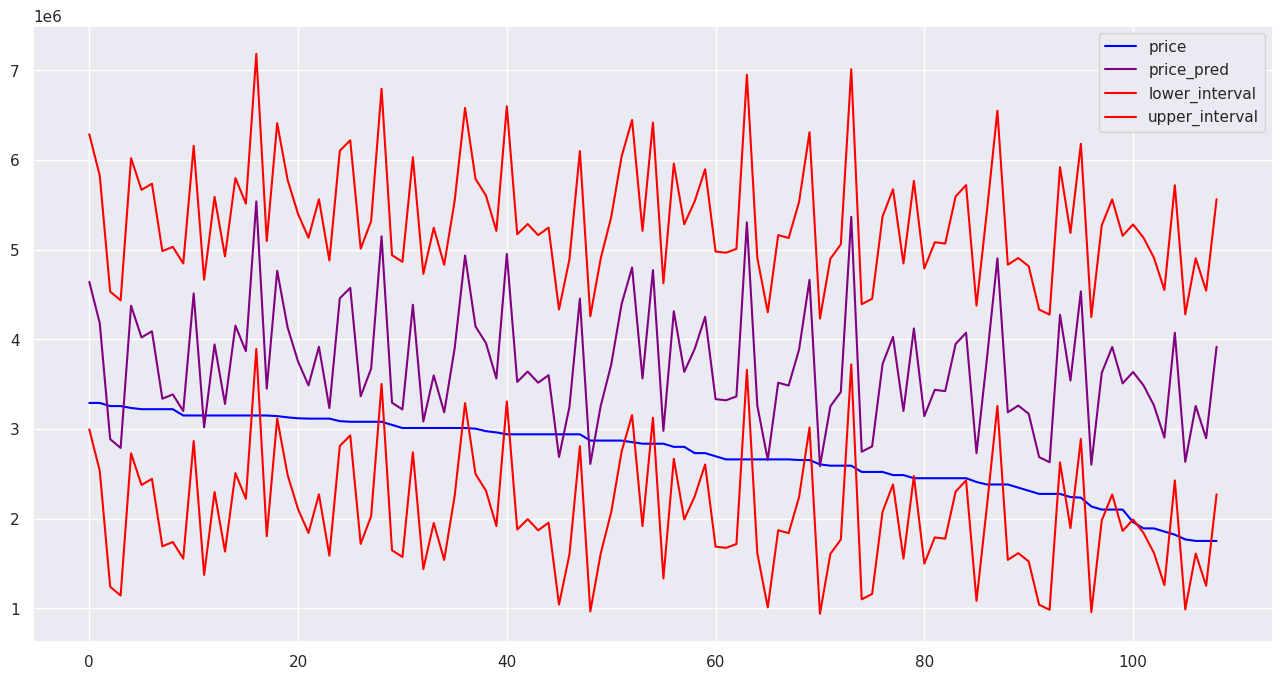

In [28]:
figsize = (16, 8)
uncertainty_colors = ['blue', 'purple', 'red', 'red']
uncertainty_df[price_cols].plot(figsize=figsize, color=uncertainty_colors)

In [29]:
coverage = (uncertainty_df['price']>=uncertainty_df['lower_interval'])&(uncertainty_df['price']<=uncertainty_df['upper_interval'])

In [30]:
coverage.sum()/len(coverage)

0.8440366972477065